# Using the AGN / QSO Summary Catalog MASKBITS
##### Authors: B. Canning, S Juneau, M, Mezcua

This is an example notebook which demonstrates use cases fo the AGN/QSO summary catalog.

See AGNQSO_summary_cat.ipynb for credits

### 1) First let's import some stuff!

In [13]:
# Numpy
import numpy as np
# Plotting stuff and suppressing boring warnings
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore')

# Get the GQP code
import sys
# Set the path where the py scripts are
sys.path.append("../py/")
import set_agn_masksDESI

# Below: delete if not needed (TO DO)
#import yaml
#import pandas as pd
#import os.path
#import fitsio

# Import Astropy libraries - useful for many astronomy related function
from astropy.table import Table #, join, Column
from astropy.io import fits

# DESI modules
#from desispec.zcatalog import find_primary_spectra, create_summary_catalog  # at NERSC needs DESI master
#from desitarget.targetmask import desi_mask, bgs_mask, scnd_mask      # For the main survey
#from desiutil.bitmask import BitMask

#https://www.legacysurvey.org/viewer?ra=10.1572&dec=-0.3316&layer=ls-dr9&zoom=16

settings = {
    'font.size':16,
    'axes.linewidth':2.0,
    'xtick.major.size':6.0,
    'xtick.minor.size':4.0,
    'xtick.major.width':2.0,
    'xtick.minor.width':1.,
    'xtick.direction':'in', 
    'xtick.minor.visible':True,
    'xtick.top':True,
    'ytick.major.size':6.0,
    'ytick.minor.size':4.0,
    'ytick.major.width':2.0,
    'ytick.minor.width':1.,
    'ytick.direction':'in', 
    'ytick.minor.visible':True,
    'ytick.right':True,
    'axes.labelsize':18
}
#    'xlabel.fontsize':18,
#    'ylabel.fontsize':18
#    }

plt.rcParams.update(**settings)

### 2) Now we are ready to open the catalog.

The internal GQP drive at NERSC is

        /global/cfs/cdirs/desi/science/gqp/

From there we can find the 'agncatalog' folder and follow the link on to 'catalog'

In [14]:
def return_catdir(location='nersc'):

    dl_path = '~/data/DESI/science/gqp/agncatalog/catalog/'
    nersc_path = '/global/cfs/cdirs/desi/science/gqp/agncatalog/catalog/'

    if location=='datalab':
        return(dl_path)
    else:
        return(nersc_path)  #default

In [15]:
catdir = return_catdir(location='nersc')

# Open the catalog
#agn_hdul = fits.open(f'{catdir}agnqso_sum_v1.4.fits', format='fits')
#agn_hdul.info()

# testing
agn_hdul = fits.open(f'{catdir}agnqso_sum_dev160524tmp.fits', format='fits')
agn_hdul.info()

Filename: /global/cfs/cdirs/desi/science/gqp/agncatalog/catalog/agnqso_sum_dev160524tmp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    325   2847435R x 149C   [K, D, D, K, 6A, J, D, D, 4A, E, I, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, 7A, 6A, J, E, J, L, K, L, K, K, K, K, K, K, K, K, K, K, K, K, K, K, D, D, 1A, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, K, K]   


As we can see the data is stored in extension number 1.

In [16]:
# Load this into an astropy table
T = Table(agn_hdul[1].data)

Let's print the columns in this catalog.

In [17]:
# What are the columns?
T.columns

<TableColumns names=('TARGETID','Z','ZERR','ZWARN','SPECTYPE','COADD_FIBERSTATUS','TARGET_RA','TARGET_DEC','MORPHTYPE','EBV_1','MASKBITS','COADD_NUMEXP','COADD_EXPTIME','TSNR2_LYA','TSNR2_QSO','DELTA_CHI2_MGII','A_MGII','SIGMA_MGII','B_MGII','VAR_A_MGII','VAR_SIGMA_MGII','VAR_B_MGII','Z_RR','Z_QN','C_LYA','C_CIV','C_CIII','C_MgII','C_Hbeta','C_Halpha','Z_LYA','Z_CIV','Z_CIII','Z_MgII','Z_Hbeta','Z_Halpha','QSO_MASKBITS','SURVEY','PROGRAM','HEALPIX','TSNR2_LRG','SV_NSPEC','SV_PRIMARY','ZCAT_NSPEC','ZCAT_PRIMARY','NPIXELS','DESI_TARGET','BGS_TARGET','SCND_TARGET','CMX_TARGET','SV1_DESI_TARGET','SV1_BGS_TARGET','SV1_SCND_TARGET','SV2_DESI_TARGET','SV2_BGS_TARGET','SV2_SCND_TARGET','SV3_DESI_TARGET','SV3_BGS_TARGET','SV3_SCND_TARGET','QN_C_LINE_BEST','QN_C_LINE_SECOND_BEST','PHOTSYS','LS_ID','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','FLUX_G','FLUX_R','FLUX_Z','FLUX_W1','FLUX_W2','FLUX_W3','FLUX_W4','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z'

In particular we acess information about the AGN and QSO diagnostics via the AGN_MASKBITS and AGN_TYPE columns. We can read the definitions for the bitmasks in the yaml file.

In [18]:
QSO_MASKBITS, AGN_MASKBITS, AGN_TYPE = set_agn_masksDESI.get_qso_maskbits('../py/agnmask.yaml')

These are the bitmask which contain the infomation. The format of these bitmasks is:    

    - [name of the target bit,  bit value,  "description as a string"]
    
For example:

    - [NII_SY,           8, "NII BPT Seyfert"]
    
This means the name of the target bit is NII_SY, its bit value is 2$^{8}$ and its description is a Seyfert object according to the NII BPT.

So let's see what the bitmasks look like.

In [19]:
print(QSO_MASKBITS)

QSO_MASKBITS:
  - [RR,               1, "RR determines this to be a QSO from template fitting"]
  - [MGII,             2, "MgII afterburner detects broad line"]
  - [QN,               3, "Quasar Net reclassifies as a QSO"]
  - [QN_NEW_RR,        4, "Quasar Net prompts different RR redshift"]


In [20]:
print(AGN_MASKBITS)

AGN_MASKBITS:
  - [AGN_ANY,          0, "any agn classification is set"]
  - [RR,               1, "RR determines this to be a QSO from template fitting"]
  - [MGII,             2, "MgII afterburner detects broad line"]
  - [QN,               3, "Quasar Net reclassifies as a QSO"]
  - [QN_NEW_RR,        4, "Quasar Net prompts different RR redshift"]
  - [BPT_ANY_SY,       5, "At least one BPT diagnostic indicates SEYFERT"]
  - [BPT_ANY_AGN,      6, "At least one BPT diagnostic indicates SEYFERT, LINER or COMPOSITE"]
  - [OPT_OTHER_AGN,    7, "Rest frame optical emission lines diagnostic not bpt (4000-10000 ang) indicate agn"]
  - [UV,               8, "Rest frame UV emission lines indicate agn"]
  - [WISE,             9, "Infrared (WISE) colours indicate agn"]
  - [XRAY,            10, "X-rays indicate agn"]
  - [RADIO,           11, "Radio indicates agn"]


In [21]:
print(AGN_TYPE)

AGN_TYPE:
  - [UNKNOWN,          0, "Unknown agn type"]
  - [TYPE1,            1, "Type 1 agn (FWHM>1500 km/s or >1000 km/s in a Balmer line)"]
  - [TYPE2,            2, "Type 2 agn (FWHM<1500 km/s or <1000 km/s in a Balmer line)"]
  - [BPT_SY,           3, "Any BPT diagnostic indicates Seyfert"]
  - [BPT_LINER,        4, "Any BPT diagnostic indicates LINER"]
  - [NII_BPT_AV,       5, "NII BPT diagnostic is avalible"]
  - [NII_SF,           6, "NII BPT Star-forming"]
  - [NII_COMP,         7, "NII BPT Composite"]
  - [NII_SY,           8, "NII BPT Seyfert"]
  - [NII_LINER,        9, "NII BPT LINER"]
  - [NII_QUIES,       10, "NII BPT Quiescent, Lines detected with (S/N) < 3"]
  - [SII_BPT_AV,      11, "SII BPT diagnostic is available"]
  - [SII_SF,          12, "SII BPT Star-forming"]
  - [SII_SY,          13, "SII BPT Seyfert"]
  - [SII_LINER,       14, "SII BPT LINER"]
  - [SII_QUIES,       15, "SII BPT Quiescent, Lines detected with (S/N) < 3"]
  - [OI_BPT_AV,       16, "OI BPT dian

## 1) How to find the number of certain classes

### Examples: NII BPT LINER and Star-forming (SF) galaxies

In [22]:
is_nii_liner = (T['AGN_TYPE'] & AGN_TYPE.NII_LINER != 0)
len(T[is_nii_liner])

4077

In [23]:
is_nii_sf = (T['AGN_TYPE'] & AGN_TYPE.NII_SF != 0)
len(T[is_nii_sf])

155350

## 2) Dump the columns to a simple csv file for the BPT diagram (Baldwin et al 1981)

### We need [NII]/Halpha vs. [OIII]/Hbeta

In [15]:
# change to be one column with sf, sy, liner etc as the value in the column

T_test=T[0:5]

cols_id=['TARGETID','SURVEY','PROGRAM']
cols_wanted=['NII_BPT_AV', 'NII_SF', 'NII_COMP', 'NII_SY', 'NII_LINER', 'NII_QUIES']
cols_tot=cols_id+cols_wanted
print(cols_tot)

append_cols=[]
for i in cols_id:
    append_cols.append(T_test[i])
    
for i in cols_wanted:
    is_col = (T_test['AGN_TYPE'] & AGN_TYPE[i] != 0)
    append_cols.append(is_col)

array_tot=np.array(append_cols)

#np.savetxt('test_array.csv', array_tot.T, header=str(cols_tot), delimiter=',',fmt='%s')

array_tot[:5]

['TARGETID', 'SURVEY', 'PROGRAM', 'NII_BPT_AV', 'NII_SF', 'NII_COMP', 'NII_SY', 'NII_LINER', 'NII_QUIES']


array([['-810889526', '-810889518', '-810889492', '-810889491',
        '-810889472'],
       ['sv2', 'sv2', 'sv2', 'sv2', 'sv2'],
       ['backup', 'backup', 'backup', 'backup', 'backup'],
       ['False', 'False', 'False', 'False', 'False'],
       ['False', 'False', 'False', 'False', 'False']], dtype='<U21')

### 3) Cross-match with Fastspecfit catalog to obtain emission-line fluxes



### 4) Let's try to filter by some AGN diagnostics and plot the result.

Let's begin with the BPT plots.

To plot the BPT plots we'll need to find the logarithm of the ratios needed for the x and y axes.

In [24]:
xx_bptnii=np.log10(T['NII_6584_FLUX']/T['HALPHA_FLUX'])
xx_bptsii=np.log10((T['SII_6716_FLUX']+T['SII_6731_FLUX'])/T['HALPHA_FLUX'])
xx_bptoi=np.log10(T['OI_6300_FLUX']/T['HALPHA_FLUX'])
yy_bpt=np.log10(T['OIII_5007_FLUX']/T['HBETA_FLUX'])

Now let's use our bitmask to filter these vectors. 

As an example let's think about how we might filter the NII BPT star-forming objects. In the AGN_TYPE bitmask the star-forming objects are defined with:

    AGN_TYPE:
    ...
    - [NII_SF,           6, "NII BPT Star-forming"]
    ...
    
Accessing the AGN_TYPE column of our table, T, is done through:

    T['AGN_TYPE']
    
This is where the numeric value associated with our binary number is stored. 
    
We filter a bitmask by identfying a bit that is flipped to a 1. 2^0=1, 2^1=10, 2^2=100, 2^3=1000...

So for example if T['AGN_TYPE'] is 11 then the binary represenation would be 1011 formed from 11 = 8+2+1 = 2^3+2^1+2^0 = 1000 + 10 + 1. 

In this case for the first 4 bitvalues we would find:

for bitnumber of 11

    is 2^0 true = 1
    is 2^1 true = 1
    is 2^2 true = 0
    is 2^3 true = 1
    
in pseudo code we could express this as

    is_0 = ( 11 & 2^0 != 0)
    is_1 = ( 11 & 2^1 != 0)
    is_2 = ( 11 & 2^2 != 0)
    is_3 = ( 11 & 2^3 != 0)
    
Now let's return to think about the case of is our 'AGN_TYPE' diagnostic NII_SF. We could write this as:    

    is_nii_sf = (T['AGN_TYPE'] & AGN_TYPE.NII_SF != 0)
    
So now let's try this below.

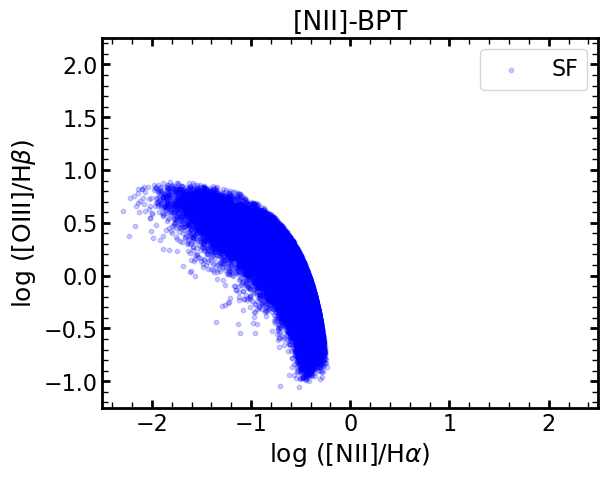

In [25]:
is_nii_sf = (T['AGN_TYPE'] & AGN_TYPE.NII_SF != 0)

# Let's plot these filtered values
plt.title('[NII]-BPT')
plt.scatter(xx_bptnii[is_nii_sf], yy_bpt[is_nii_sf], color = 'b', s = 10, label='SF', alpha=0.2)
plt.xlabel('log ([NII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')
plt.xlim(-2.5,2.5)
plt.ylim(-1.25,2.25)
plt.legend()
plt.show()

Now let's try filtering and printing the NII, SII and OI BPT plot.

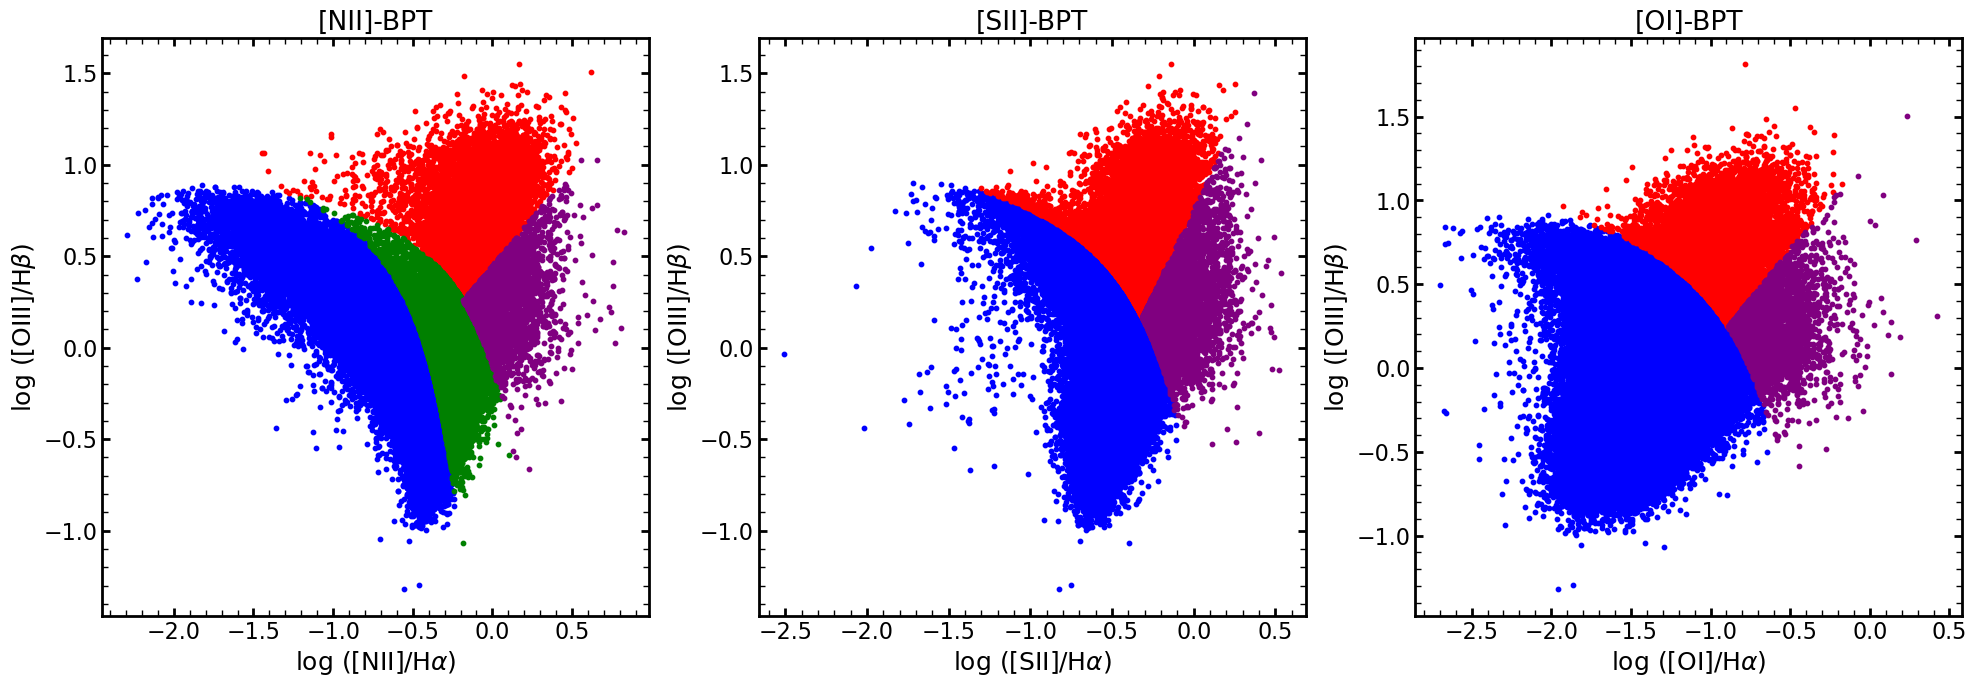

In [26]:
is_nii_sf = (T['AGN_TYPE'] & AGN_TYPE.NII_SF != 0)
is_nii_sy = (T['AGN_TYPE'] & AGN_TYPE.NII_SY != 0)
is_nii_lin = (T['AGN_TYPE'] & AGN_TYPE.NII_LINER != 0)
is_nii_comp = (T['AGN_TYPE'] & AGN_TYPE.NII_COMP != 0)

is_sii_sf = (T['AGN_TYPE'] & AGN_TYPE.SII_SF != 0)
is_sii_sy = (T['AGN_TYPE'] & AGN_TYPE.SII_SY != 0)
is_sii_lin = (T['AGN_TYPE'] & AGN_TYPE.SII_LINER != 0)

is_oi_sf = (T['AGN_TYPE'] & AGN_TYPE.OI_SF != 0)
is_oi_sy = (T['AGN_TYPE'] & AGN_TYPE.OI_SY != 0)
is_oi_lin = (T['AGN_TYPE'] & AGN_TYPE.OI_LINER != 0)

plt.figure(figsize = (24,7.5))

plt.subplot2grid((1,3), (0,0))
plt.title('[NII]-BPT')
plt.scatter(xx_bptnii[is_nii_sf], yy_bpt[is_nii_sf], color = 'b', s = 10)
plt.scatter(xx_bptnii[is_nii_sy], yy_bpt[is_nii_sy], color = 'r', s = 10)
plt.scatter(xx_bptnii[is_nii_comp], yy_bpt[is_nii_comp], color = 'g', s = 10)
plt.scatter(xx_bptnii[is_nii_lin], yy_bpt[is_nii_lin], color = 'purple', s = 10)
plt.xlabel('log ([NII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')

plt.subplot2grid((1,3), (0,1))
plt.title('[SII]-BPT')
plt.scatter(xx_bptsii[is_sii_sf], yy_bpt[is_sii_sf], color = 'b', s = 10)
plt.scatter(xx_bptsii[is_sii_sy], yy_bpt[is_sii_sy], color = 'r', s = 10)
plt.scatter(xx_bptsii[is_sii_lin], yy_bpt[is_sii_lin], color = 'purple', s = 10)
plt.xlabel('log ([SII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')

plt.subplot2grid((1,3), (0,2))
plt.title('[OI]-BPT')
plt.scatter(xx_bptoi[is_oi_sf], yy_bpt[is_oi_sf], color = 'b', s = 10)
plt.scatter(xx_bptoi[is_oi_sy], yy_bpt[is_oi_sy], color = 'r', s = 10)
plt.scatter(xx_bptoi[is_oi_lin], yy_bpt[is_oi_lin], color = 'purple', s = 10)
plt.xlabel('log ([OI]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')

plt.show()

In [33]:
# AGN_MASKBITS BPT_ANY_SY BPT_ANY_AGN
mask_is_any_sy = (T['AGN_MASKBITS'] & AGN_MASKBITS.BPT_ANY_SY != 0)
mask_is_any_agn = (T['AGN_MASKBITS'] & AGN_MASKBITS.BPT_ANY_AGN != 0)

is_any_sy = (is_nii_sy | is_sii_sy | is_oi_sy)
is_any_agn = (is_nii_sy | is_sii_sy | is_oi_sy | is_nii_lin | is_sii_lin | is_oi_lin | is_nii_comp)

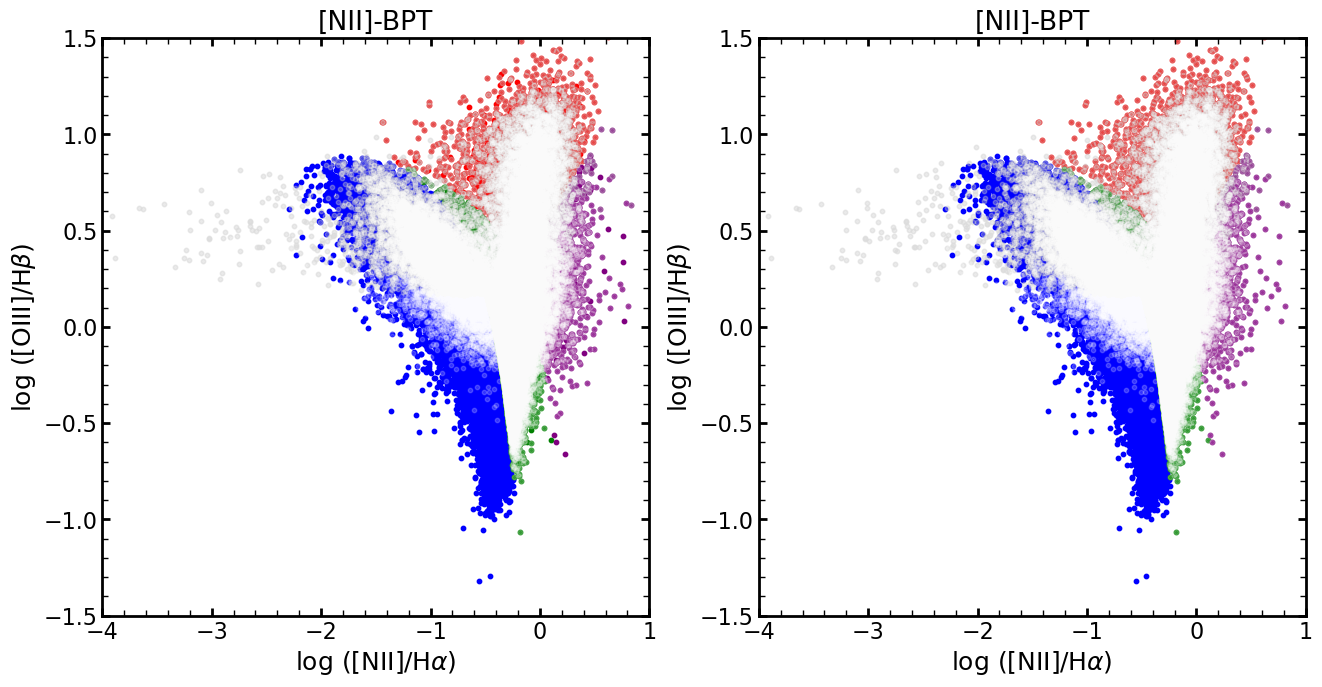

In [37]:
plt.figure(figsize = (24,7.5))

plt.subplot2grid((1,3), (0,0))
plt.title('[NII]-BPT')
plt.scatter(xx_bptnii[is_nii_sf], yy_bpt[is_nii_sf], color = 'b', s = 10)
plt.scatter(xx_bptnii[is_nii_sy], yy_bpt[is_nii_sy], color = 'r', s = 10)
plt.scatter(xx_bptnii[is_nii_comp], yy_bpt[is_nii_comp], color = 'g', s = 10)
plt.scatter(xx_bptnii[is_nii_lin], yy_bpt[is_nii_lin], color = 'purple', s = 10)

plt.scatter(xx_bptnii[mask_is_any_sy], yy_bpt[mask_is_any_sy], color = 'grey', s = 10, alpha=0.2)
plt.scatter(xx_bptnii[mask_is_any_agn], yy_bpt[mask_is_any_agn], color = 'white', s = 10, alpha=0.2)

plt.xlabel('log ([NII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')

plt.xlim(-4,1)
plt.ylim(-1.5,1.5)
#

plt.subplot2grid((1,3), (0,1))
plt.title('[NII]-BPT')
plt.scatter(xx_bptnii[is_nii_sf], yy_bpt[is_nii_sf], color = 'b', s = 10)
plt.scatter(xx_bptnii[is_nii_sy], yy_bpt[is_nii_sy], color = 'r', s = 10)
plt.scatter(xx_bptnii[is_nii_comp], yy_bpt[is_nii_comp], color = 'g', s = 10)
plt.scatter(xx_bptnii[is_nii_lin], yy_bpt[is_nii_lin], color = 'purple', s = 10)

plt.scatter(xx_bptnii[is_any_sy], yy_bpt[is_any_sy], color = 'grey', s = 10, alpha=0.2)
plt.scatter(xx_bptnii[is_any_agn], yy_bpt[is_any_agn], color = 'white', s = 10, alpha=0.2)

plt.xlabel('log ([NII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')

plt.xlim(-4,1)
plt.ylim(-1.5,1.5)


# plt.subplot2grid((1,3), (0,1))
# plt.title('[SII]-BPT')
# plt.scatter(xx_bptsii[is_sii_sf], yy_bpt[is_sii_sf], color = 'b', s = 10)
# plt.scatter(xx_bptsii[is_sii_sy], yy_bpt[is_sii_sy], color = 'r', s = 10)
# plt.scatter(xx_bptsii[is_sii_lin], yy_bpt[is_sii_lin], color = 'purple', s = 10)

# plt.scatter(xx_bptnii[is_any_sy], yy_bpt[is_any_sy], color = 'grey', s = 10, alpha=0.3)
# plt.scatter(xx_bptnii[is_any_agn], yy_bpt[is_any_agn], color = 'white', s = 10, alpha=0.3)

# plt.xlabel('log ([SII]/H$\\alpha$)')
# plt.ylabel('log ([OIII]/H$\\beta$)')

# plt.subplot2grid((1,3), (0,2))
# plt.title('[OI]-BPT')
# plt.scatter(xx_bptoi[is_oi_sf], yy_bpt[is_oi_sf], color = 'b', s = 10)
# plt.scatter(xx_bptoi[is_oi_sy], yy_bpt[is_oi_sy], color = 'r', s = 10)
# plt.scatter(xx_bptoi[is_oi_lin], yy_bpt[is_oi_lin], color = 'purple', s = 10)
# plt.xlabel('log ([OI]/H$\\alpha$)')
# plt.ylabel('log ([OIII]/H$\\beta$)')

plt.show()

### 5) What about the intersections of some AGN diagnostics.

First let's try to build a BPT where we allow the objects to be placed in the BPT if they are SY, SF or LINERS in any of the three BPT plots. This will double up on some objects.

In [16]:
is_any_sf = (is_nii_sf | is_sii_sf | is_oi_sf)
is_any_sy = (is_nii_sy | is_sii_sy | is_oi_sy)
is_any_lin = (is_nii_lin | is_sii_lin | is_oi_lin)

NameError: name 'is_sii_sf' is not defined

NameError: name 'xx_bptnii' is not defined

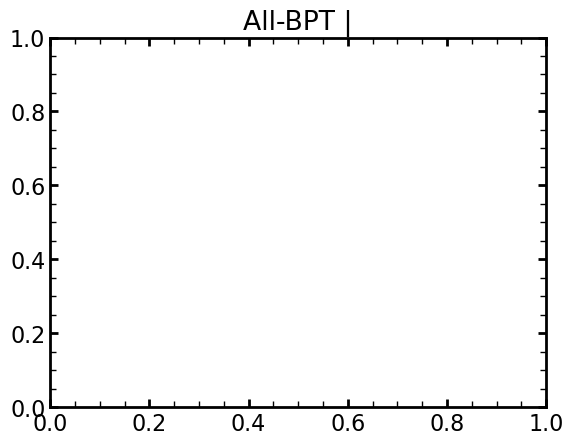

In [17]:
plt.title('All-BPT |')
plt.scatter(xx_bptnii[is_any_sf], yy_bpt[is_any_sf], color = 'b', s = 2, label='SF', alpha=0.1)
plt.scatter(xx_bptnii[is_any_sy], yy_bpt[is_any_sy], color = 'r', s = 2, label='SY', alpha=0.1)
plt.scatter(xx_bptnii[is_any_lin], yy_bpt[is_any_lin], color = 'purple', s = 2, label='LINER', alpha=0.1)
plt.xlabel('log ([NII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')
plt.xlim(-3,2)
plt.legend()
plt.show()

Now let's try to build a BPT where we only filter the objects which are considered to be seyferts, liners and star-formings regions in all three plots at once. Let's plot this on the NII plot.

In [15]:
is_sf = (is_nii_sf & is_sii_sf & is_oi_sf)
is_sy = (is_nii_sy & is_sii_sy & is_oi_sy)
is_lin = (is_nii_lin & is_sii_lin & is_oi_lin)

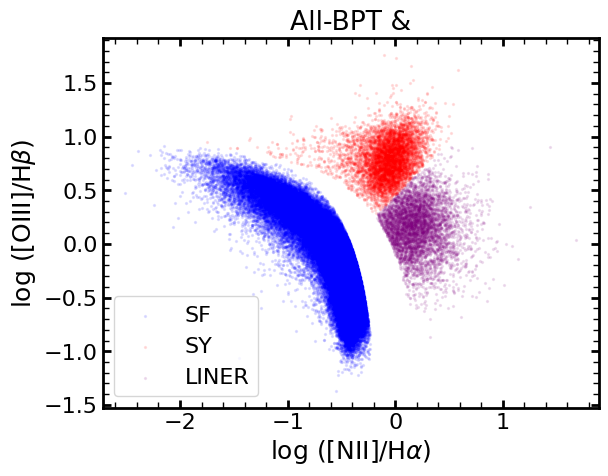

In [16]:
plt.title('All-BPT &')
plt.scatter(xx_bptnii[is_sf], yy_bpt[is_sf], color = 'b', s = 2, label='SF', alpha=0.1)
plt.scatter(xx_bptnii[is_sy], yy_bpt[is_sy], color = 'r', s = 2, label='SY', alpha=0.1)
plt.scatter(xx_bptnii[is_lin], yy_bpt[is_lin], color = 'purple', s = 2, label='LINER', alpha=0.1)
plt.xlabel('log ([NII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')
plt.legend()
plt.show()

Now lets try plotting the WISE AGN on top of these

In [17]:
is_wise = (T['AGN_TYPE'] & AGN_TYPE.WISE_AGN != 0)

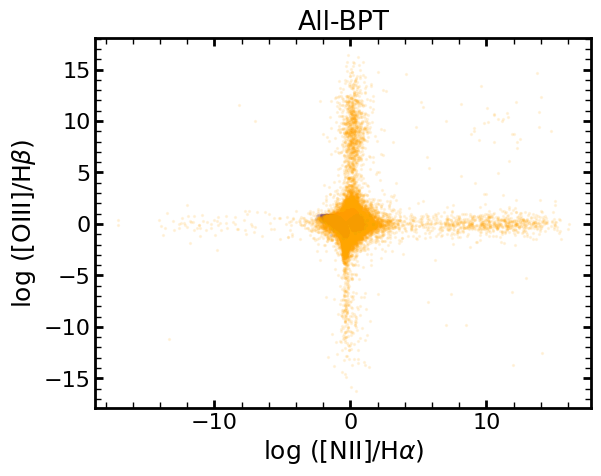

In [18]:
plt.title('All-BPT')
plt.scatter(xx_bptnii[is_sf], yy_bpt[is_sf], color = 'b', s = 2, alpha=0.1)
plt.scatter(xx_bptnii[is_sy], yy_bpt[is_sy], color = 'r', s = 2, alpha=0.1)
plt.scatter(xx_bptnii[is_lin], yy_bpt[is_lin], color = 'purple', s = 2, alpha=0.1)
plt.scatter(xx_bptnii[is_wise], yy_bpt[is_wise], color = 'orange', s = 2, alpha=0.1)
plt.xlabel('log ([NII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')
plt.show()

The star now seen as many of the WISE AGN have a very low s/n in some of the emission lines. Let's filter for sn>3 in NII, OIII, Ha and Hb too. 

In [19]:
nii_sn=T['NII_6584_FLUX']*np.sqrt(T['NII_6584_FLUX_IVAR'])
ha_sn=T['HALPHA_FLUX']*np.sqrt(T['HALPHA_FLUX_IVAR'])
oiii_sn=T['OIII_5007_FLUX']*np.sqrt(T['OIII_5007_FLUX_IVAR'])
hb_sn=T['HBETA_FLUX']*np.sqrt(T['HBETA_FLUX_IVAR'])

is_sig = (nii_sn > 3) & (ha_sn > 3) & (oiii_sn > 3) & (hb_sn > 3)

In [20]:
is_wise_sig = is_wise & is_sig

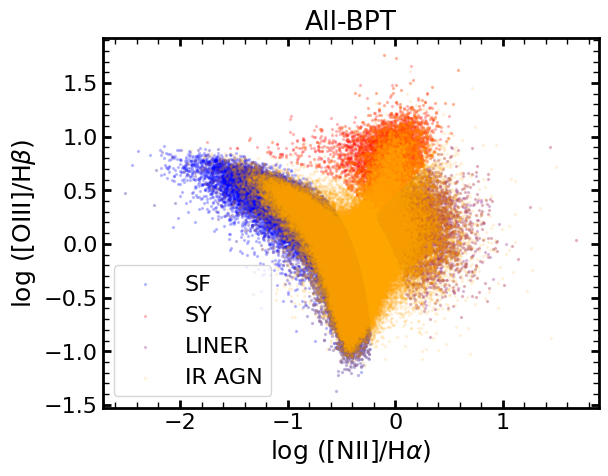

In [21]:
plt.title('All-BPT')
plt.scatter(xx_bptnii[is_sf], yy_bpt[is_sf], color = 'b', s = 2, label='SF', alpha=0.2)
plt.scatter(xx_bptnii[is_sy], yy_bpt[is_sy], color = 'r', s = 2, label='SY', alpha=0.2)
plt.scatter(xx_bptnii[is_lin], yy_bpt[is_lin], color = 'purple', s = 2, label='LINER', alpha=0.2)
plt.scatter(xx_bptnii[is_wise_sig], yy_bpt[is_wise_sig], color = 'orange', s = 2, alpha=0.1, label='IR AGN')
plt.xlabel('log ([NII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')
plt.legend()
plt.show()

### 6) We can also use the AGN_diagnostics code which makes these cuts to plot diagnostic lines. 

In [22]:
from AGNdiagnosticsFunctionsDESI import NII_BPT_lines

In [23]:
print(NII_BPT_lines.__doc__)


    BPT regions
    
    Kewley et al. 2001: starburst vs AGN classification.
    Kew01_nii: log10(flux_oiii_5006/flux_hbeta)=0.61/(log10(flux_nii_6583/flux_halpha)-0.47)+1.19

    Kauffmann et al. 2003: starburst vs composites.
    Ka03: log10(flux_oiii_5006/flux_hbeta)=0.61/(log10(flux_nii_6583/flux_halpha)-0.05)+1.3
    
    Schawinsky et al. 2007: Seyferts vs LINERS
    Scha07: log10(flux_oiii_5006/flux_hbeta)=1.05*log10(flux_nii_6583/flux_halpha)+0.45
    
    Other BPT regions not implemented here yet:
    
    Law et al. 2021 proposed revised lines based on MaNGA observation (not implemented b/c similar to Ka03):
log10(flux_oiii_5006/flux_hbeta)=0.438/(log10(flux_nii_6583/flux_halpha)+0.023)+1.222
    
    Law et al. define an extra "intermediate" region (not yet implemented)
    


In [24]:
x_axes=np.linspace(-3,2,70)
Kew01_nii, Ka03, Scha07 = NII_BPT_lines(x_axes)

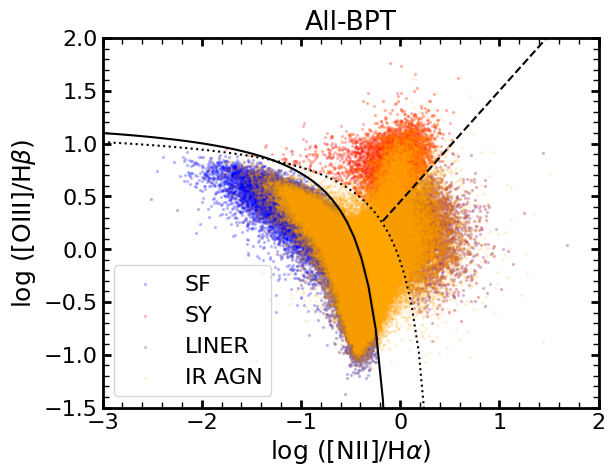

In [25]:
plt.title('All-BPT')

plt.plot(x_axes,Kew01_nii, color='black', ls=':')
plt.plot(x_axes,Scha07, color='black', ls='--')
plt.plot(x_axes,Ka03, color='black', ls='-')

plt.scatter(xx_bptnii[is_sf], yy_bpt[is_sf], color = 'b', s = 2, label='SF', alpha=0.2)
plt.scatter(xx_bptnii[is_sy], yy_bpt[is_sy], color = 'r', s = 2, label='SY', alpha=0.2)
plt.scatter(xx_bptnii[is_lin], yy_bpt[is_lin], color = 'purple', s = 2, label='LINER', alpha=0.2)
plt.scatter(xx_bptnii[is_wise_sig], yy_bpt[is_wise_sig], color = 'orange', s = 2, alpha=0.1, label='IR AGN')
plt.xlabel('log ([NII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')
plt.xlim(-3,2)
plt.ylim(-1.5,2)
plt.legend()
plt.show()

### 7) IR diagnostic diagram: WISE Color-Color

In [34]:
w1w2 = -2.5*np.log10(T['FLUX_W1']/T['FLUX_W2'])
w2w3 = -2.5*np.log10(T['FLUX_W2']/T['FLUX_W3'])
w2 = 22.5 - 2.5*np.log10(T['FLUX_W2'])

snr_w1 = T['FLUX_W1']*np.sqrt(T['FLUX_IVAR_W1'])
snr_w2 = T['FLUX_W2']*np.sqrt(T['FLUX_IVAR_W2'])
snr_w3 = T['FLUX_W3']*np.sqrt(T['FLUX_IVAR_W3'])

In [35]:
thres = 3.
detect_w1w2 = (snr_w1>thres)&(snr_w2>thres)
detect_w1w2w3 = (snr_w1>thres)&(snr_w2>thres)&(snr_w3>thres)

Text(0, 0.5, 'W1-W2 [AB]')

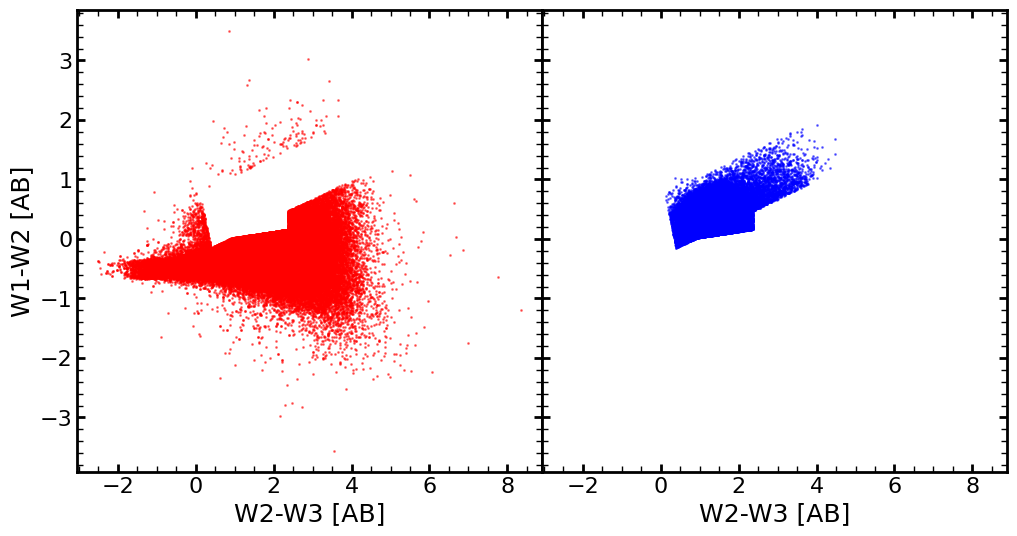

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0)

ax1.scatter(w2w3[is_wise&detect_w1w2w3], w1w2[is_wise&detect_w1w2w3], color='r', s=1, alpha=0.5)

ax2.scatter(w2w3[~is_wise&detect_w1w2w3], w1w2[~is_wise&detect_w1w2w3], color='b', s=1, alpha=0.5)

for ax in [ax1, ax2]:
    ax.set_xlabel('W2-W3 [AB]')
ax1.set_ylabel('W1-W2 [AB]')

Text(0, 0.5, 'W1-W2 [AB]')

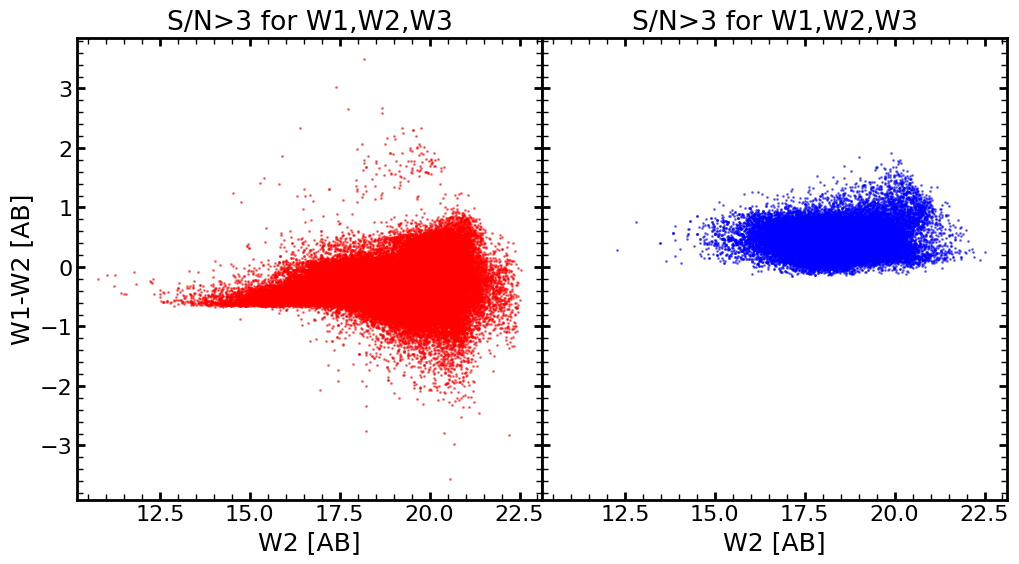

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0)

ax1.scatter(w2[is_wise&detect_w1w2w3], w1w2[is_wise&detect_w1w2w3], color='r', s=1, alpha=0.5)
ax2.scatter(w2[~is_wise&detect_w1w2w3], w1w2[~is_wise&detect_w1w2w3], color='b', s=1, alpha=0.5)

for ax in [ax1, ax2]:
    ax.set_xlabel('W2 [AB]')
    ax.set_title('S/N>3 for W1,W2,W3')
ax1.set_ylabel('W1-W2 [AB]')

Text(0, 0.5, 'W1-W2 [AB]')

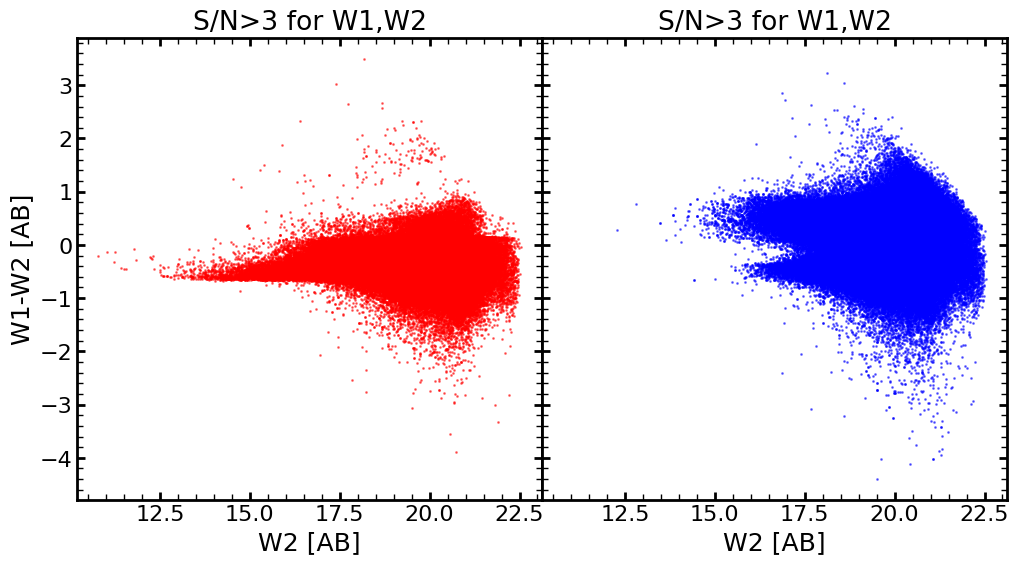

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0)

ax1.scatter(w2[is_wise&detect_w1w2], w1w2[is_wise&detect_w1w2], color='r', s=1, alpha=0.5)
ax2.scatter(w2[~is_wise&detect_w1w2], w1w2[~is_wise&detect_w1w2], color='b', s=1, alpha=0.5)

for ax in [ax1, ax2]:
    ax.set_xlabel('W2 [AB]')
    ax.set_title('S/N>3 for W1,W2')
ax1.set_ylabel('W1-W2 [AB]')